In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

In [161]:
# Loading the housing price dataset (assuming the file name is "housing_price.csv")
df = pd.read_csv("/Users/verapinto/Desktop/LABS/lab-eda-univariate/amz_uk_price_prediction_dataset.csv")
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [162]:
# Counting and sorting the unique values for each object (string) column in descending order
df.select_dtypes("object").nunique().sort_values(ascending=False)

asin        2222742
title       2077591
category        296
dtype: int64

In [163]:
# Counting and sorting the unique values for each numerical column in descending order
df.select_dtypes("number").nunique().sort_values(ascending=False)

uid                  2443651
price                  82916
reviews                19446
stars                     42
boughtInLastMonth         25
dtype: int64

## Part 1: Analyzing Best-Seller Trends Across Product Categories
### Objective: Understand the relationship between product categories and their best-seller status.

In [165]:
#Crosstab Analysis: A table showing the frequency of occurrences for combinations of two categorical variables.
#1. Create a crosstab between the product category and the isBestSeller status.
#Are there categories where being a best-seller is more prevalent?
#Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result['best_seller_proportion'] = crosstab_result[True] / crosstab_result.sum(axis=1)
sorted_categories = crosstab_result.sort_values('best_seller_proportion', ascending=False).head(10)
sorted_categories


isBestSeller,False,True,best_seller_proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
"Billiard, Snooker & Pool",241,8,0.032129
Pet Supplies,9152,285,0.030200
Home Brewing & Wine Making,239,7,0.028455
Wind Instruments,243,7,0.028000


In [166]:
high_prevalence_categories = sorted_categories[sorted_categories['best_seller_proportion'] > 0.05]
high_prevalence_categories

#Answer: Yes, the categories where a best-seller is more prevalent are Grocery, Smart Home Security & Lighting and Helth & Personal Care.

isBestSeller,False,True,best_seller_proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686


In [167]:
#Statistical Tests:
#2. Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
#Compute Cramér's V to understand the strength of association between best-seller status and category.

from scipy.stats import chi2_contingency
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)
chi2_statistic, chi2_p_value

#Interpretation: 
#if p-value < 0.05, this suggests that there is a significant association between the categorical variables. 
#P-value >= 0.05, indicates that there is not enough evidence to conclude a significant association between the variables.

#H0: best-seller distribution is independent of the product category
#Given the extremely low ( p )-value, we reject the null hypothesis. This implies that there's a significant association between Best-seller and product category in the dataset.

(36684.23786636857, 0.0)

In [168]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.

from scipy.stats.contingency import association
cramer_v = association(pd.crosstab(df['category'], df['isBestSeller']), method="cramer")
print(cramer_v)

#Interpretation: 
#Cramer's V ranges from 0 to 1, where 0 indicates no association, and 1 represents a perfect association between the variables. 
#A higher value of Cramer's V indicates a stronger relationship between the categorical variables.

#The Cramér's V value of 0.122 suggests a weak association between the two variables.

0.1222829439760564


Text(0, 0.5, 'Count')

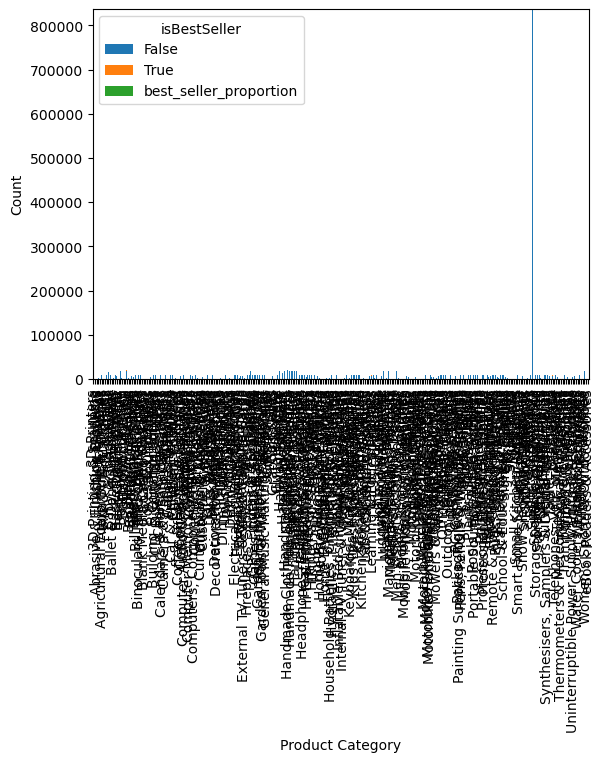

In [169]:
#Visualizations:
#3. Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
crosstab_result.plot(kind="bar", stacked=True)
plt.xlabel("Product Category")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

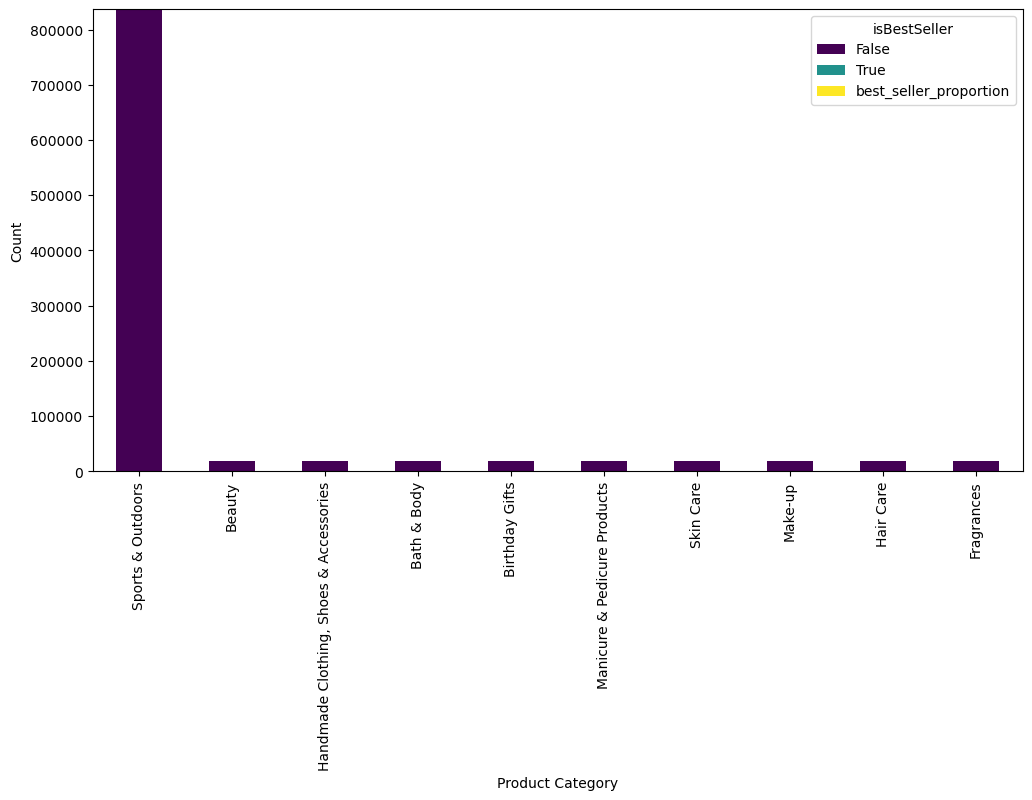

In [171]:
top_10_categories = crosstab_result.sum(axis=1).nlargest(10).index
filtered_crosstab = crosstab_result.loc[top_10_categories]
filtered_crosstab.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Product Category")
plt.ylabel("Count")

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands
### Objective: Investigate how different product categories influence product prices.

In [173]:
#0.Preliminary Step: Remove outliers in product prices.
#For this purpose, we can use the IQR (Interquartile Range) method. 
#Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. 
#The next steps will be done with the dataframe without outliers.
#Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove outliers
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Display the cleaned dataset
df_filtered.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1272/1999596329.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='category', y='price', data=filtered_df, scale='width', inner='quartile')


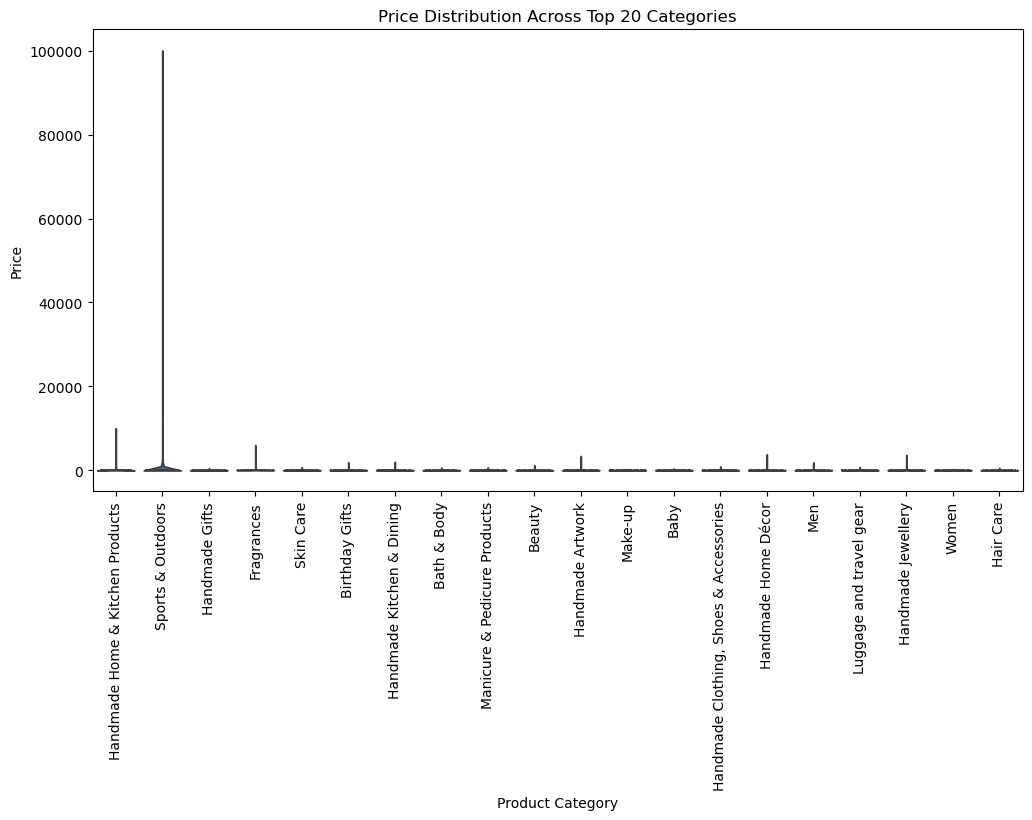

The category with the highest median price is 'Laptops' with a median price of 1042.725.


In [174]:
#Violin Plots:
#1.Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
#Which product category tends to have the highest median price? Don't filter here by top categories.

# Select the top 20 categories based on count
top_20_categories = df['category'].value_counts().nlargest(20).index
filtered_df = df[df['category'].isin(top_20_categories)]

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='category', y='price', data=filtered_df, scale='width', inner='quartile')
plt.xlabel("Product Category")
plt.ylabel("Price")
plt.title("Price Distribution Across Top 20 Categories")
plt.xticks(rotation=90)
plt.show()

median_prices = df.groupby('category')['price'].median()
highest_median_category = median_prices.idxmax()
highest_median_price = median_prices.max()

print(f"The category with the highest median price is '{highest_median_category}' with a median price of {highest_median_price}.")


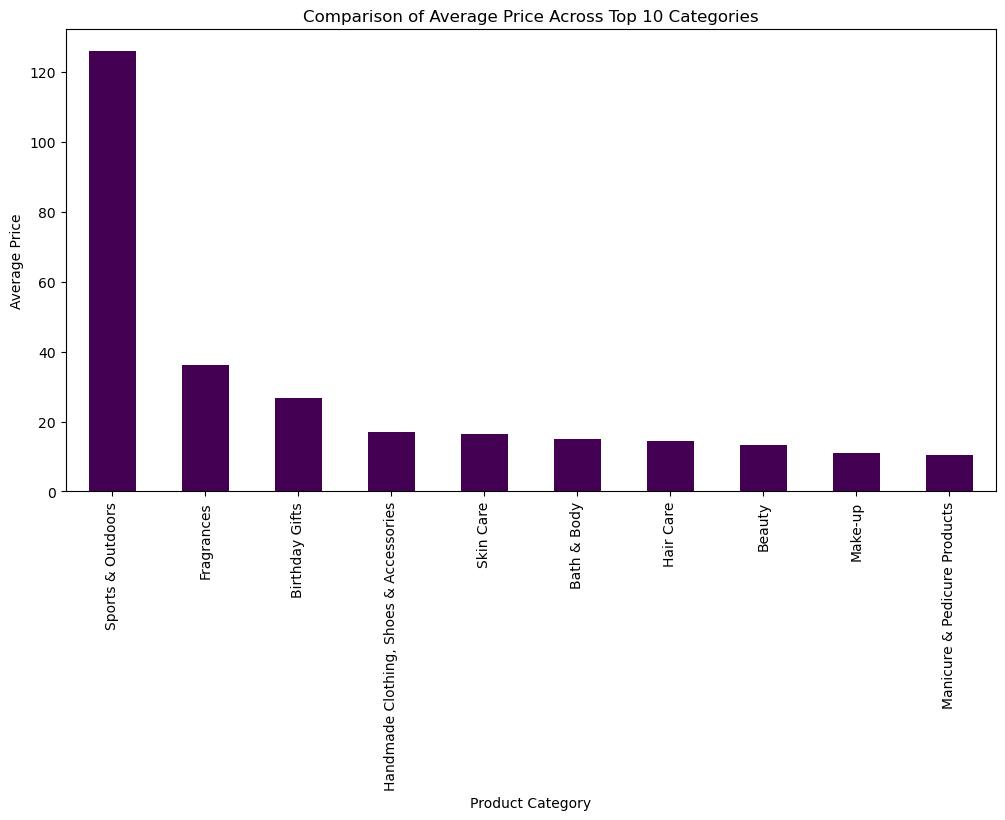

The category with the highest average price is 'Laptops' with an average price of 1087.987826986755.


In [176]:
#Bar Charts:
#2.Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
#Which product category commands the highest average price? Don't filter here by top categories.

# Identify top 10 categories based on product count
top_10_categories = df['category'].value_counts().nlargest(10).index

# Calculate average price for these categories
avg_price_df = df[df['category'].isin(top_10_categories)].groupby('category')['price'].mean()

# Create the bar chart
plt.figure(figsize=(12, 6))
avg_price_df.sort_values(ascending=False).plot(kind='bar', colormap='viridis')

plt.xlabel("Product Category")
plt.ylabel("Average Price")
plt.title("Comparison of Average Price Across Top 10 Categories")
plt.xticks(rotation=90)
plt.show()


highest_avg_category = df.groupby('category')['price'].mean().idxmax()
highest_avg_price = df.groupby('category')['price'].mean().max()

print(f"The category with the highest average price is '{highest_avg_category}' with an average price of {highest_avg_price}.")


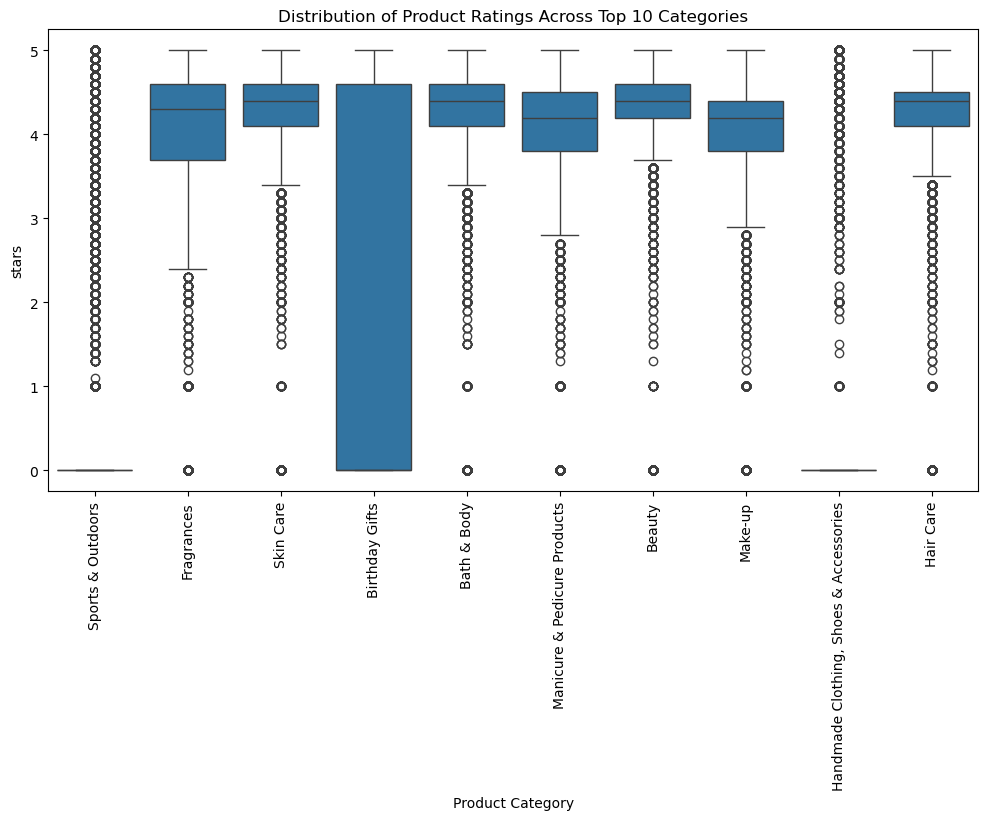

The category with the highest median rating is 'Computer Memory' with a median rating of 4.7.


In [177]:
#Box Plots:
#3.Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

# Select the top 10 categories based on count
top_10_categories = df['category'].value_counts().nlargest(10).index
filtered_df = df[df['category'].isin(top_10_categories)]

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=filtered_df)

plt.xlabel("Product Category")
plt.ylabel("stars")
plt.title("Distribution of Product Ratings Across Top 10 Categories")
plt.xticks(rotation=90)
plt.show()


median_ratings = df.groupby('category')['stars'].median()
highest_median_category = median_ratings.idxmax()
highest_median_rating = median_ratings.max()

print(f"The category with the highest median rating is '{highest_median_category}' with a median rating of {highest_median_rating}.")


## Part 3: Investigating the Interplay Between Product Prices and Ratings
### Objective: Analyze how product ratings (stars) correlate with product prices.

In [179]:
#Correlation Coefficients:
#1.Calculate the correlation coefficient between price and stars.
#Is there a significant correlation between product price and its rating?

correlation_coefficient = df['price'].corr(df['stars'], method='pearson')
print(f"The correlation coefficient between price and rating is {correlation_coefficient:.4f}")

#Remember, correlation values range from -1 to 1:
#A value close to 1 implies a strong positive correlation.
#A value close to -1 implies a strong negative correlation.
#A value close to 0 implies little to no linear/monotonic correlation.

#A correlation coefficient of -0.1249 indicates a weak negative correlation between price and rating.
#The negative sign suggests that as price increases, ratings tend to slightly decrease, but the relationship is not strong.
#Since -0.1249 is close to 0, this means that price and rating are not significantly related. Meaning, customer ratings don’t strongly depend on the price of a product.
#It’s possible that consumers rate products based on quality, usability, or expectations, rather than price alone.

The correlation coefficient between price and rating is -0.1249


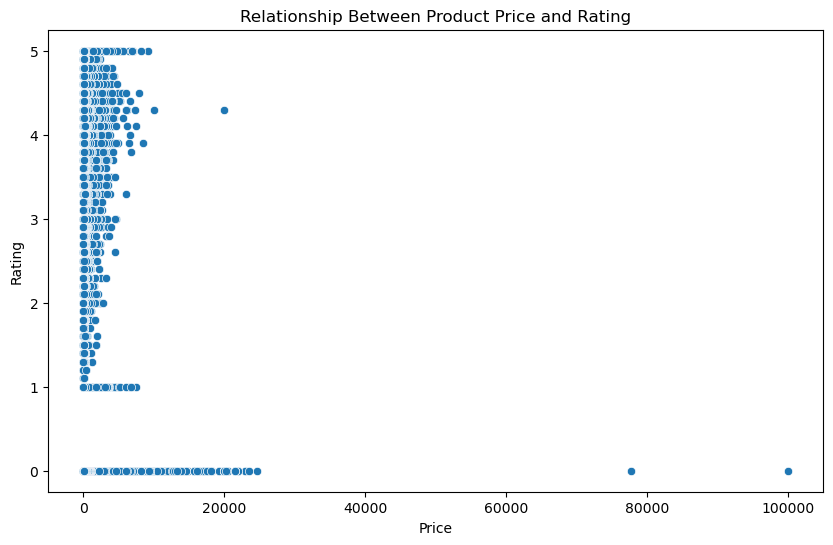

In [182]:
#Visualizations:
#2.Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
#Use a correlation heatmap to visualize correlations between all numerical variables.
#Examine if product prices typically follow a normal distribution using a QQ plot.

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['price'], y=df['stars'])
plt.xlabel("Price")
plt.ylabel("Rating")
plt.title("Relationship Between Product Price and Rating")
plt.show()

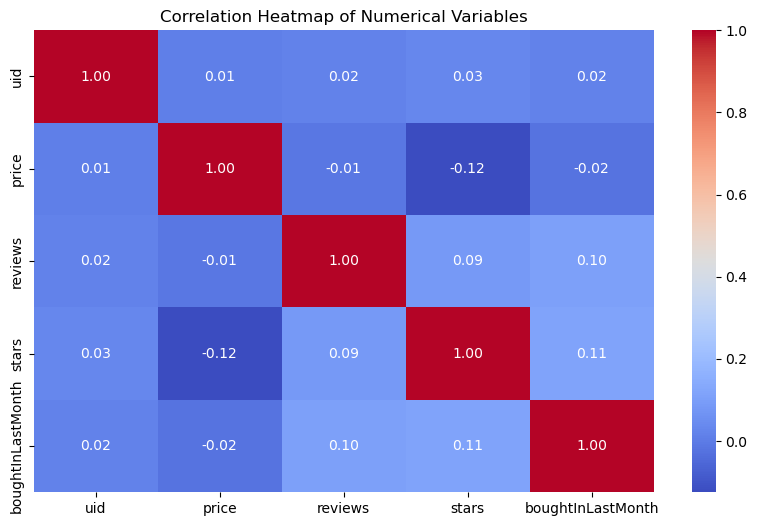

In [194]:
#Use a correlation heatmap to visualize correlations between all numerical variables.

# Select numerical variables for correlation analysis
numerical_cols = ['uid', 'price', 'reviews', 'stars', 'boughtInLastMonth']

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr(method="pearson")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

<Figure size 800x600 with 0 Axes>

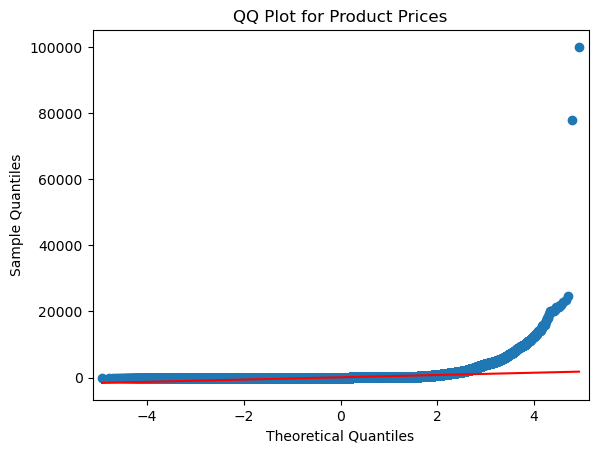

In [188]:
#Examine if product prices typically follow a normal distribution using a QQ plot.

plt.figure(figsize=(8, 6))
sm.qqplot(df['price'], line='s');

plt.title("QQ Plot for Product Prices")
plt.show()

#Upper Tail: In the upper tail (right side of the plot), the data points deviate significantly from the red line, suggesting a long tail or skewness to the right. 
#This indicates that there are more extreme high values in price than would be expected in a normal distribution.